<a href="https://colab.research.google.com/github/justinf34/SENG550-Project/blob/main/CreatingModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/MyDrive/Colab Notebooks/SENG550/dataset/') # Chaging to dataset dir
print(os.listdir())

['LeagueofLegends.csv', 'gold.csv', '_columns.csv', 'bans.csv', 'kills.csv', 'monsters.csv', 'structures.csv', 'matchinfo.csv', 'Reference-Dataset', 'model_features', 'mid_model_features', 'mid_model_features_wh', 'mid_model_features_wh2']


In [3]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 65kB/s 
     |████████████████████████████████| 204kB 2.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=aa9ef1c0fa4192fcb239eab23f3e3cfe5dc70cd980f90940444c6b09c486f82c
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [143]:
!pip install handyspark 

# Model Creation

In [4]:
# Setting up Spark context using SparkSession
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('predictor-models').master("local[*]").getOrCreate()

### Loading the Data

In [5]:

mid_df = spark.read.csv('./mid_model_features_wh2/part-*.csv', header=True, inferSchema=True)
mid_df.printSchema()

root
 |-- winner: string (nullable = true)
 |-- mid_golddiff: integer (nullable = true)
 |-- bKillCount: integer (nullable = true)
 |-- rKillCount: integer (nullable = true)
 |-- first_blood: string (nullable = true)
 |-- bTowerCount: integer (nullable = true)
 |-- rTowerCount: integer (nullable = true)
 |-- first_tower: string (nullable = true)
 |-- bInhibCount: integer (nullable = true)
 |-- rInhibCount: integer (nullable = true)
 |-- first_inhib: string (nullable = true)
 |-- bDragonCount: integer (nullable = true)
 |-- rDragonCount: integer (nullable = true)
 |-- first_dragon: string (nullable = true)
 |-- bBaronCount: integer (nullable = true)
 |-- rBaronCount: integer (nullable = true)
 |-- first_baron: string (nullable = true)



**Features:**

- `mid_goldiff`: This is be the difference between the gold in each team. Computed by Blue(1) - Red(0) gold.
- `bKillCount`: The number of kills that the Blue side has.
- `rKillCount`: The number of kills that the Red side has.
- `first_blood`: Which team got the first kills of the game.
- `bTowerCount`: The number of towers that the Blue side knocked down.
- `rTowerCount`: The number of towers that the Red side knocked down.
- `first_tower`: Which team knocked down the first tower of the game.
- `bInhibCount`: The number of inhibitors that the Blue side knocked down.
- `rInhibCount`: The number of inhibitors that the Red side knocked down.
- `first_inhib`: Which team knocked down the first inhibitor of the game.
- `bDragonCount`: The number of dragons that the Blue side has.
- `rDragonCount`: The number of dragons that the Red side has.
- `first_dragon`: Which team got the first dragon of the game.
- `bBaronCount`: The number of barons that the Blue side has.
- `rBaronCount`: The number of barons that the Red side has.
- `first_baron`: Which team got the first baron of the game

**Label:**

- `winner`: Indicates which team won the match



Looking at the first 5 matches in our dataset

In [8]:
import pandas as pd
pd.DataFrame(mid_df.take(5), columns=mid_df.columns).transpose()

,0,1,2,3,4
winner,Blue,Red,Blue,Red,Blue
mid_golddiff,1422,1368,5293,2712,-730
bKillCount,4,5,11,5,1
rKillCount,3,3,6,5,1
first_blood,Blue,Blue,Blue,Red,Blue
bTowerCount,4,1,3,2,1
rTowerCount,2,1,0,1,3
first_tower,Blue,Read,Blue,Blue,Read
bInhibCount,0,0,0,0,0
rInhibCount,0,0,0,0,0


Below we can see that the number of records where blue is the winner and when red is the winner is almost balanced.

In [7]:
mid_df.groupby('winner').count().toPandas()

,winner,count
0,Blue,4146
1,Red,3474


### Summary Statistics

Here we can see the mean, standard deviation, max, and min for our numerical variables.

In [ ]:
numeric_data = [t[0] for t in mid_df.dtypes if t[1] == 'int']
mid_df.select(numeric_data).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
mid_golddiff,7620,209.72086614173227,2817.02348085286,-13591,12673
bKillCount,7620,3.862992125984252,2.802155522367613,0,31
rKillCount,7620,3.744225721784777,2.825049109605663,0,20
bTowerCount,7620,1.7263779527559056,1.323631865981659,0,8
rTowerCount,7620,1.5360892388451444,1.2876729076787756,0,9
bInhibCount,7620,0.0032808398950131233,0.06573059977889233,0,3
rInhibCount,7620,0.0034120734908136482,0.07053997021908105,0,4
bDragonCount,7620,0.6570866141732283,0.7255637472953317,0,4
rDragonCount,7620,0.75748031496063,0.7647421170462376,0,5


## Model Building

### Preparing Data

Before we can create models, we must prepare our data so that the model can use our data and estimate parameters needed to predict game results. The data has already been altered during the firt phase of data preprocessing, however, we need to encode categroical features to numerical since machine learning models can only work with numbers. Also, we need to normalize our numeric features. This is necessar because the numeric features are in very different ranges. Numeric features that have larger values such as gold difference can influence the result more due to its larger values, however, this feature might not be as important as the other features.

#### Encoding Categorical Features

In [9]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# Creating coverting categorical feature to  numerical representations
categorical_features = [t[0] for t in mid_df.dtypes if t[1] == 'string' and t[0] != 'winner' ]
stages_v1 = [] # Stages in our Pipeline

for col in categorical_features:
  strIndexer = StringIndexer(inputCol=col, outputCol=col + "Index")
  encoder = OneHotEncoder(inputCols=[strIndexer.getOutputCol()], outputCols=[col + "classVec"])
  stages_v1 += [strIndexer, encoder]

Since we doing a binary classification, our label is also categorical which we have to convert to numerical. Our label only have category which means that we can use integer encoding rather than one-hot encoding.

In [10]:
label_strIndexer = StringIndexer(inputCol="winner", outputCol="label")
stages_v1 += [label_strIndexer]

#### Normalizing Numeric Features

In [11]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

num_features = [t[0] for t in mid_df.dtypes if t[1] == 'int']

for col in num_features:
  assembler = VectorAssembler(inputCols=[col], outputCol=col + "_Vect")
  scaler = MinMaxScaler(inputCol=assembler.getOutputCol(), outputCol=col+"_Scaled")
  stages_v1 +=[assembler,scaler]


#### Combining All Features
Now, we will combine all the features columns into a single vector column that we will call `features` which will be the input data to our models.

In [12]:
from pyspark.ml.feature import VectorAssembler

assemblerInputs = [col + "classVec" for col in categorical_features] + [col + "_Scaled" for col in num_features]
assembler2 = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages_v1 += [assembler2]

Now that we have defined all our data transformations, it still has not been applied to our data. They will be applied when we start training a model. Below will be the number of transformations that our data will go through.

In [13]:
stages_v1

[StringIndexer_9f1bfe08de55,
 OneHotEncoder_997938304287,
 StringIndexer_10965c18fdca,
 OneHotEncoder_23ef30ccccf3,
 StringIndexer_fefb3658b300,
 OneHotEncoder_22f9dfdca563,
 StringIndexer_3f1f423182c9,
 OneHotEncoder_75f2f1221960,
 StringIndexer_342501467e00,
 OneHotEncoder_6be882c4a00d,
 StringIndexer_e5b6c7fdb792,
 VectorAssembler_f0590a936610,
 MinMaxScaler_e17b16ae7f88,
 VectorAssembler_626b9d148f7b,
 MinMaxScaler_f87f5c90e1e8,
 VectorAssembler_6e6261eac6ca,
 MinMaxScaler_594614242705,
 VectorAssembler_2d9b3c0ac9c7,
 MinMaxScaler_84784a1f2df5,
 VectorAssembler_32da88e6b589,
 MinMaxScaler_799c9f22f0e6,
 VectorAssembler_c90a4d92aaa7,
 MinMaxScaler_7a43268627b2,
 VectorAssembler_36556d2d5ecf,
 MinMaxScaler_24a6a89394da,
 VectorAssembler_0eefe26cd1c3,
 MinMaxScaler_d6389732e8e9,
 VectorAssembler_494320d7a553,
 MinMaxScaler_4addafd7f7b7,
 VectorAssembler_1549727c8e47,
 MinMaxScaler_38bc6c0fe867,
 VectorAssembler_16fa5de68ef1,
 MinMaxScaler_881abf0627ec,
 VectorAssembler_b331d6e55cbf]

In [14]:
from pyspark.ml import Pipeline

pipeline = Pipeline().setStages(stages_v1)
pipelineModel = pipeline.fit(mid_df)
transformed_data = pipelineModel.transform(mid_df)

In [15]:
selectedCols = ['label', 'features'] + mid_df.columns
model_df = transformed_data.select(selectedCols)
model_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- winner: string (nullable = true)
 |-- mid_golddiff: integer (nullable = true)
 |-- bKillCount: integer (nullable = true)
 |-- rKillCount: integer (nullable = true)
 |-- first_blood: string (nullable = true)
 |-- bTowerCount: integer (nullable = true)
 |-- rTowerCount: integer (nullable = true)
 |-- first_tower: string (nullable = true)
 |-- bInhibCount: integer (nullable = true)
 |-- rInhibCount: integer (nullable = true)
 |-- first_inhib: string (nullable = true)
 |-- bDragonCount: integer (nullable = true)
 |-- rDragonCount: integer (nullable = true)
 |-- first_dragon: string (nullable = true)
 |-- bBaronCount: integer (nullable = true)
 |-- rBaronCount: integer (nullable = true)
 |-- first_baron: string (nullable = true)



In [16]:
pd.DataFrame(model_df.take(5), columns=model_df.columns).transpose()

,0,1,2,3,4
label,0,1,0,1,0
features,"(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","(0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ..."
winner,Blue,Red,Blue,Red,Blue
mid_golddiff,1422,1368,5293,2712,-730
bKillCount,4,5,11,5,1
rKillCount,3,3,6,5,1
first_blood,Blue,Blue,Blue,Red,Blue
bTowerCount,4,1,3,2,1
rTowerCount,2,1,0,1,3
first_tower,Blue,Read,Blue,Blue,Read


From the dataframe above, we can see that 0 indicates for Blue and 1 indicates for Red.

#### Splitting the data into train and test sets

In [17]:
weights = [.8, .2] # train/test split
seed = 42
trainData, testData = model_df.randomSplit(weights,seed)
print("Training Dataset Count: " + str(trainData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 6166
Test Dataset Count: 1454


### Model 1 - Logistic Regression

Now we will build our first model which use the logistic regression algorithm. This will be used as our baseline model as we explore other alogrithms and change the features we give our model.

### Initial Model

In [32]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label",\
                        featuresCol="features", \
                        maxIter=100, \
                        family="multinomial",
                        standardization = False)

# Train model with Training Data
lrModel = lr.fit(trainData)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()
# print('Training set areaUnderROC: ' + str(trainingSummary.areaAboveROC))

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#### Evaluating the Model

The first thing that we will do is evaluate our the model that we trained for  100 epochs.

In [33]:
predictions = lrModel.transform(testData)
predCols = ['mid_golddiff', 'bKillCount', 'rKillCount', 'first_blood',\
            'bTowerCount', 'rTowerCount', 'first_tower', 'bInhibCount',\
            'rInhibCount', 'first_inhib', 'bDragonCount', 'rDragonCount',\
            'first_dragon', 'bBaronCount', 'rBaronCount', 'first_baron',\
            'rawPrediction', 'prediction', 'probability']

pd.DataFrame(predictions.take(5), columns=predictions.columns).transpose()

,0,1,2,3,4
label,0,0,0,0,0
features,"(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
winner,Blue,Blue,Blue,Blue,Blue
mid_golddiff,659,1166,2128,1625,2106
bKillCount,1,4,8,4,4
rKillCount,0,1,2,1,3
first_blood,Blue,Blue,Blue,Blue,Blue
bTowerCount,0,0,0,1,1
rTowerCount,0,0,0,0,0
first_tower,Blue,Blue,Blue,Blue,Blue


In [34]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName=)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9827937376501015


### Cross-Validate Model

Here we will use Cross Validation to find the best model by determinng which epoch from 50 to 100 will produce the best performing model. For this cross validation, we are using ten-fold cross validation?

In [41]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import *
import numpy as np

lr = LogisticRegression(labelCol="label", featuresCol="features", standardization=False)

lmbd = np.arange(0,0.1,0.05)
aggrDepth = [x for x in range(2, 11)]
testIter = [x for x in range(50,101) if x%5==0]

grid = ParamGridBuilder()\
      .addGrid(lr.maxIter, testIter)\
      .addGrid(lr.aggregationDepth, aggrDepth)\
      .addGrid(lr.regParam, lmbd)\
      .build()

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName=)

cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, \
                    evaluator=evaluator, numFolds=3,\
                    parallelism=2)
cv_LR_model = cv.fit(model_df)
best_LR_Model = cv_LR_model.bestModel

Save the model so that we do not have to retrain.

In [187]:
!ls ../dataset/

bans.csv      kills.csv		   mid_model_features	   monsters.csv
_columns.csv  LeagueofLegends.csv  mid_model_features_wh   Reference-Dataset
DT_Model      LR_Model		   mid_model_features_wh2  structures.csv
gold.csv      matchinfo.csv	   model_features


In [191]:
# Saving the model
cv_LR_model.save("CV_LR_Model")
best_LR_Model.save("LR_Model")

Below we can see how well our model performed on each number of epochs. We can see that our model performs relatively the same no matter how much we increase our number of epochs from 50 to 100.

In [ ]:
cv_LR_model.avgMetrics

Parameters

In [92]:
print('maxIter', cv_LR_model.bestModel.getMaxIter())
print('regParam', cv_LR_model.bestModel.getRegParam())
print('aggregationDepth', cv_LR_model.bestModel.getAggregationDepth())

maxIter 50
regParam 0.0
aggregationDepth 10


Results

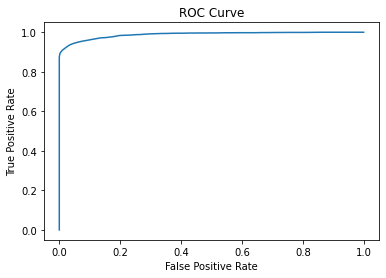

In [108]:
import matplotlib.pyplot as plt
import numpy as np

trainingSummary = best_LR_Model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

In [105]:
predictions = best_LR_Model.transform(testData)
print('Test Area Under ROC', evaluator.evaluate(predictions))
print('Train Area Under ROC', trainingSummary.areaUnderROC)

Test Area Under ROC 0.9839394284845768
Train Area Under ROC 0.989220726756454


### Model 2 - Decision Tree Classifier

Fort this model we are going to use the Decision Tree algorithm to create a model that can predict the outcome of a game.

### Initial Model

In [65]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 30)
dtModel = dt.fit(trainData)

#### Evaluating the Model

The first thing that we will do is evaluate our the model that only had a max depth of 20.

In [66]:
predictions = dtModel.transform(testData)
predCols = ['mid_golddiff', 'bKillCount', 'rKillCount', 'first_blood',\
            'bTowerCount', 'rTowerCount', 'first_tower', 'bInhibCount',\
            'rInhibCount', 'first_inhib', 'bDragonCount', 'rDragonCount',\
            'first_dragon', 'bBaronCount', 'rBaronCount', 'first_baron',\
            'rawPrediction', 'prediction', 'probability']

pd.DataFrame(predictions.take(5), columns=predictions.columns).transpose()

,0,1,2,3,4
label,0,0,0,0,0
features,"(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
winner,Blue,Blue,Blue,Blue,Blue
mid_golddiff,659,1166,2128,1625,2106
bKillCount,1,4,8,4,4
rKillCount,0,1,2,1,3
first_blood,Blue,Blue,Blue,Blue,Blue
bTowerCount,0,0,0,1,1
rTowerCount,0,0,0,0,0
first_tower,Blue,Blue,Blue,Blue,Blue


In [77]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9527426280589755


### Cross-validate Model

Here we will use Cross Validation to find the best decision tree model by trying out different max depths. For this cross validation, we are using ten-fold cross validation.

In [126]:
dt.explainParams()

"cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)\ncheckpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)\nfeaturesCol: features column name. (default: features, current: features)\nimpurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)\nlabelCol: label column name. (default: label, current: label)\nleafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )\nmaxBins: Max number of bins for d

In [132]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import *

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

testDept = [x for x in range(2,22) if x%3==0]
testBins = [x for x in range(3, 33) if x%6==0]

grid = ParamGridBuilder()\
      .addGrid(dt.maxDepth, testDept)\
      .addGrid(dt.maxBins, testBins)\
      .build()

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

cvDT = CrossValidator(estimator=dt, estimatorParamMaps=grid, evaluator=evaluator, numFolds=2)

cv_DT_model = cvDT.fit(model_df)
best_DT_Model = cv_DT_model.bestModel

In [207]:
# Saving the model
cv_DT_model.save("CV_DT_Model")
cv_DT_model.bestModel.save("DT_Model")

Below we can see how well our model performed on each number of epochs. We can see that our model performs relatively the same no matter how much we increase our number of epochs from 50 to 100.

In [138]:
cv_DT_model.avgMetrics

[0.9259894625208085,
 0.9259894625208085,
 0.9259894625208085,
 0.9259894625208085,
 0.9259894625208085,
 0.9258642725795916,
 0.9281210106871738,
 0.9251286321525685,
 0.9253422061691277,
 0.9254475210626089,
 0.9181468920871736,
 0.9262073715259678,
 0.9128981479152395,
 0.9244748501862419,
 0.9133758372870348,
 0.9269250960198008,
 0.9350184012255565,
 0.9154624752395413,
 0.9209399947039724,
 0.9156019399533748,
 0.9376787908056042,
 0.936598035117603,
 0.934746458046932,
 0.9373267884326455,
 0.9356799973638426,
 0.953151724706885,
 0.9577545469530266,
 0.9572037325111016,
 0.9553338876864652,
 0.9574004906188234,
 0.9579540211583875,
 0.9588679343093773,
 0.9569633278006253,
 0.9563495173464072,
 0.9568993537620998]

Parameters

In [142]:
print('maxDepth', best_DT_Model.getMaxDepth())
print('maxBins', best_DT_Model.getMaxBins())

maxDepth 21
maxBins 12


In [144]:
predictions = best_DT_Model.transform(testData)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9980886152910777


In [148]:
predictions

DataFrame[label: double, features: vector, winner: string, mid_golddiff: int, bKillCount: int, rKillCount: int, first_blood: string, bTowerCount: int, rTowerCount: int, first_tower: string, bInhibCount: int, rInhibCount: int, first_inhib: string, bDragonCount: int, rDragonCount: int, first_dragon: string, bBaronCount: int, rBaronCount: int, first_baron: string, rawPrediction: vector, probability: vector, prediction: double]

### Creating the ROC Graphs

In [214]:
from pyspark.ml.classification import LogisticRegressionModel
from pyspark.ml.classification import DecisionTreeClassificationModel
from pyspark.ml.classification import RandomForestClassificationModel
from handyspark import *



lr = LogisticRegressionModel.load('LR_Model')
lr_predictions = lr.transform(testData)
lr_bcm = BinaryClassificationMetrics(lr_predictions, scoreCol='probability', \
                                  labelCol='label')

dt = DecisionTreeClassificationModel.load('DT_Model')
dt_predictions = dt.transform(testData)
dt_bcm = BinaryClassificationMetrics(dt_predictions, scoreCol='probability', \
                                  labelCol='label')


rf = RandomForestClassificationModel.load('RF_Model')
rf_predictions = rf.transform(testData)
rf_bcm = BinaryClassificationMetrics(rf_predictions, scoreCol='probability', \
                                  labelCol='label')

Text(0.5, 1.0, 'Test ROC Curve for the Logistice Regression Model')

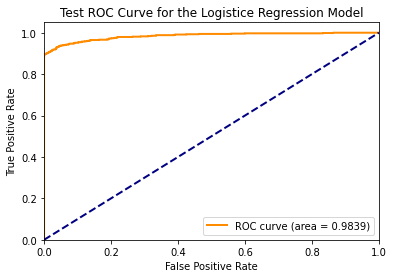

In [223]:
lr_fig, lr_axs = plt.subplots()
lr_bcm.plot_roc_curve(ax=lr_axs)
lr_axs.set_title('Test ROC Curve for the Logistice Regression Model')

Text(0.5, 1.0, 'Test ROC Curve for the Decision Tree Model')

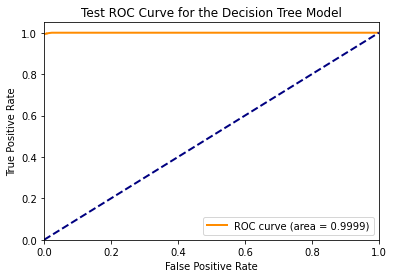

In [227]:
dt_fig, dt_axs = plt.subplots()
dt_bcm.plot_roc_curve(ax=dt_axs)
dt_axs.set_title('Test ROC Curve for the Decision Tree Model')

Text(0.5, 1.0, 'Test ROC Curve for the Random Forest Model')

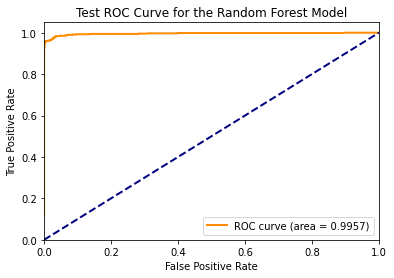

In [226]:
rf_fig, rf_axs = plt.subplots()
rf_bcm.plot_roc_curve(ax=rf_axs)
rf_axs.set_title('Test ROC Curve for the Random Forest Model')